In [35]:
import json
import pprint
from math import log

# dataset source
# https://files.pushshift.io/reddit/comments/
pp = pprint.PrettyPrinter(indent=4)

In [36]:
# access constants

ID = 'id'
BODY = 'body'
SCORE = 'score'
PARENT = 'parent_id'
LINK = 'link_id'

DATASET_FILE = 'reddit_2006jan.json'
QUERY_SUBREDDIT = 'reddit.com'

In [37]:
class Node(object):
    def __init__(self, body, score, parent, link):
        self.body = body
        self.score = score
        self.parent = parent
        self.link = link

In [38]:
# build dict of Node Objects by post id

def build_nodes_set(data):
    nodes = dict() # post_id: Node Object
    for post in data:
        nodes[post[ID]] = Node(post[BODY], post[SCORE], post[PARENT], post[LINK])
    return nodes

In [39]:
# build dict of post ids by link_id

def build_threads_set(nodes):
    threads = dict() # link_id: [post_ids]
    for post_id in nodes.keys():
        thread_id = nodes[post_id].link
        if thread_id in threads.keys():
            threads[thread_id].append(post_id)
        else:
            threads[thread_id] = [post_id]
    return threads

In [40]:
# builda dict of thread bodies by link_id

def build_thread_bodies(threads, nodes):
    thread_bodies = dict() # link_id: 'str w/ all comment text'
    for link_id in threads.keys():
        thread_bodies[link_id] = ""
        comments = threads[link_id]
        for post_id in comments:
            thread_bodies[link_id] += nodes[post_id].body

        # PARSE RULES #
        thread_bodies[link_id] = thread_bodies[link_id].replace('\n', '')
        thread_bodies[link_id] = thread_bodies[link_id].replace('\r', '')
    return thread_bodies

In [41]:
# read dataset

with open(DATASET_FILE) as file:
    train_data = json.loads(file.read())

# filter posts by subreddit

train_data = [post for post in train_data if post['subreddit'] == QUERY_SUBREDDIT]
print('{} results for query on subreddit: {}\n'.format(len(train_data), QUERY_SUBREDDIT))

# count up degenerate entries

no_id = [post for post in train_data if not ID in post]
print('{} entries without id'.format(len(no_id)))

no_body = [post for post in train_data if not BODY in post]
print('{} entries without body'.format(len(no_body)))

no_parent = [post for post in train_data if not PARENT in post]
print('{} entries without parent'.format(len(no_parent)))

no_link = [post for post in train_data if not LINK in post]
print('{} entries without link'.format(len(no_link)))

3664 results for query on subreddit: reddit.com

0 entries without id
0 entries without body
0 entries without parent
0 entries without link


In [42]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
#from stop_words import get_stop_words
from gensim import corpora, models

import numpy as np
import time

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_distances
from scipy import spatial

In [44]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print('Topic {}:'.format(topic_idx))
        print(' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print('')

In [45]:
NUM_TOPICS = 5
NUM_WORDS = 5
PASSES = 20

nodes = build_nodes_set(train_data)
threads = build_threads_set(nodes)
thread_bodies = build_thread_bodies(threads, nodes)

# train LDA model

start = time.time()

train = list(thread_bodies.values())
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf_train = tf_vectorizer.fit_transform(train)
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(n_topics=NUM_TOPICS, max_iter=PASSES, learning_method='online', learning_offset=50.,random_state=0)
lda.fit(tf_train)

display_topics(lda, tf_feature_names, NUM_WORDS)

end = time.time()

print('time elapsed: {} seconds'.format(end - start))

Topic 0:
deleted windows vim emacs factorial

Topic 1:
people like think just don

Topic 2:
oil google war video anti

Topic 3:
just like people think don

Topic 4:
http com www reddit link

time elapsed: 5.252831935882568 seconds


In [46]:
# test prediction 

with open('reddit_2005dec.json') as file:
    test_data = json.loads(file.read())

nodes = build_nodes_set(test_data)
threads = build_threads_set(nodes)
thread_bodies = build_thread_bodies(threads, nodes)

# comment_bodies = { node_id: node.body for (node_id, node) in nodes.items() }
# test_set = list(comment_bodies.values())

test_set = list(thread_bodies.values())
tf_test = tf_vectorizer.fit_transform(test_set)
predict = lda.transform(tf_test)

pp.pprint(predict[:3])
print('')
print(test_set[0] + '\n')
print(test_set[1] + '\n')
print(test_set[2] + '\n\n')

pp.pprint(predict[-3:])
print('')
print(test_set[-3] + '\n')
print(test_set[-2] + '\n')
print(test_set[-1] + '\n\n')

array([[ 0.05232976,  0.53655661,  0.05006991,  0.30852102,  0.0525227 ],
       [ 0.00745875,  0.57534911,  0.00761521,  0.144825  ,  0.26475192],
       [ 0.06667518,  0.72823481,  0.0710696 ,  0.06733943,  0.06668097]])

A look at Vietnam and Mexico exposes the myth of market liberalisation.

The site states "What can I use it for? Meeting notes, Reports, technical specs Sign-up sheets, proposals and much more...", just like any other new breeed of sites that want us to store everything we have on the web. And they even guarantee multiple levels of security and encryption etc. But what prevents these web site operators fom accessing and/or stealing Meeting notes, Reports, technical specs Sign-up sheets, proposals and much more, for competitive or personal gains...? I am pretty sure that most of them are honest, but what's there to prevent me from setting up a good useful site and stealing all your data? Call me paranoid - I am.

Jython related topics by Frank Wierzbicki


array([[ 0

In [47]:
print('predictions available for {} elements\n'.format(len(predict)))
pp.pprint(predict)

predictions available for 396 elements

array([[ 0.05232976,  0.53655661,  0.05006991,  0.30852102,  0.0525227 ],
       [ 0.00745875,  0.57534911,  0.00761521,  0.144825  ,  0.26475192],
       [ 0.06667518,  0.72823481,  0.0710696 ,  0.06733943,  0.06668097],
       ..., 
       [ 0.156999  ,  0.41127412,  0.10943053,  0.25145537,  0.07084097],
       [ 0.00691655,  0.63011907,  0.04981258,  0.00733707,  0.30581473],
       [ 0.02222729,  0.21748446,  0.02280595,  0.71453702,  0.02294528]])


In [51]:
# Create matrix that stores cosine distances between predictions
# We use this because we don't care about the length of the vectors
start = time.time()

cos_dist_matrix = cosine_distances(predict, predict)

end = time.time()

print('time elapsed: {} seconds'.format(end - start))

time elapsed: 0.002514362335205078 seconds


In [54]:
# Calculate the distance threshold we should use
# Currently std is really high and makes our graph very crowded
# What is a good way to do this
import networkx as nx
import matplotlib.pyplot as plt

In [55]:
# ASSUMPTION: dict.keys() and dict.values() directly correspond if not modified
# rehydrate node_ids into dist_matrix -> distance lookup table
change_dict = {}
mult_val = 0
while mult_val <= 10:
    DIST_THRES = np.std(cos_dist_matrix) * 0.01 * mult_val
    print(DIST_THRES)
    max_dist = float('-inf')

    dist_lookup = { node_id: {} for node_id in thread_bodies.keys() }
    for idx1, first in enumerate(list(dist_lookup.keys())):
        for idx2, second in enumerate(list(dist_lookup.keys())):
            dist_lookup[first][second] = 1 if cos_dist_matrix[idx1][idx2] <= DIST_THRES else 0
            max_dist = cos_dist_matrix[idx1][idx2] if cos_dist_matrix[idx1][idx2] > max_dist else max_dist
    #         dist_lookup[first][second] = dist_matrix[idx1][idx2] # lazy eval

    # check

    mistakes = 0
    for i in dist_lookup.keys():
        for j in dist_lookup.keys():
            if i==j and dist_lookup[i][j] != 1:
                mistakes += 1
            if dist_lookup[i][j] != dist_lookup[j][i]:
                mistakes += 1

    #print('max distance seen: {}'.format(max_dist))
    #print('{} mistakes out of {} entries'.format(mistakes, len(dist_lookup) * len(dist_lookup)))
    g = nx.Graph()
    for thread_id in thread_bodies.keys():
        g.add_node(thread_id)

    for first in thread_bodies.keys():
        for second in thread_bodies.keys():
            if not g.has_edge(first, second) and dist_lookup[first][second] == 1:
                g.add_edge(first, second)
    
    print(nx.is_connected(g))
    degs = nx.degree_histogram(g)
    # plt.hist(degs, normed=True, bins=len(degs))
    # nx.density(g)
    print(nx.info(g))
    graphs = list(nx.connected_component_subgraphs(g))
    Gc = max(nx.connected_component_subgraphs(g), key=len)
    print(len(Gc))
    change_dict[mult_val] = len(Gc)
    mult_val = mult_val + 1
    

0.0
False
Name: 
Type: Graph
Number of nodes: 396
Number of edges: 532
Average degree:   2.6869
13
0.00280950489042
False
Name: 
Type: Graph
Number of nodes: 396
Number of edges: 1493
Average degree:   7.5404
37
0.00561900978084
False
Name: 
Type: Graph
Number of nodes: 396
Number of edges: 1898
Average degree:   9.5859
175
0.00842851467126
False
Name: 
Type: Graph
Number of nodes: 396
Number of edges: 2471
Average degree:  12.4798
193
0.0112380195617
False
Name: 
Type: Graph
Number of nodes: 396
Number of edges: 3305
Average degree:  16.6919
239
0.0140475244521
False
Name: 
Type: Graph
Number of nodes: 396
Number of edges: 3834
Average degree:  19.3636
260
0.0168570293425
False
Name: 
Type: Graph
Number of nodes: 396
Number of edges: 4512
Average degree:  22.7879
271
0.0196665342329
False
Name: 
Type: Graph
Number of nodes: 396
Number of edges: 5173
Average degree:  26.1263
275
0.0224760391234
False
Name: 
Type: Graph
Number of nodes: 396
Number of edges: 5674
Average degree:  28.6566

In [ ]:
def save_and_show_visualization(g, file_name):
    plt.figure(figsize=(18,18))
    degrees = dict(nx.degree(g))
    
    # Draw networkx graph -- scale node size by log(degree+1)
    nx.draw_spring(g, with_labels=False, 
                   linewidths=2.0,
                   nodelist=degrees.keys(),
                   node_size=[log(degree_val+1) * 100 for degree_val in degrees.values()], \
                   node_color='r')
    
    # Create black border around node shapes
    ax = plt.gca()
    ax.collections[0].set_edgecolor("#000000")

    # Save and show figure, then clear figure
    plt.savefig(file_name)
    plt.show()
    plt.clf()

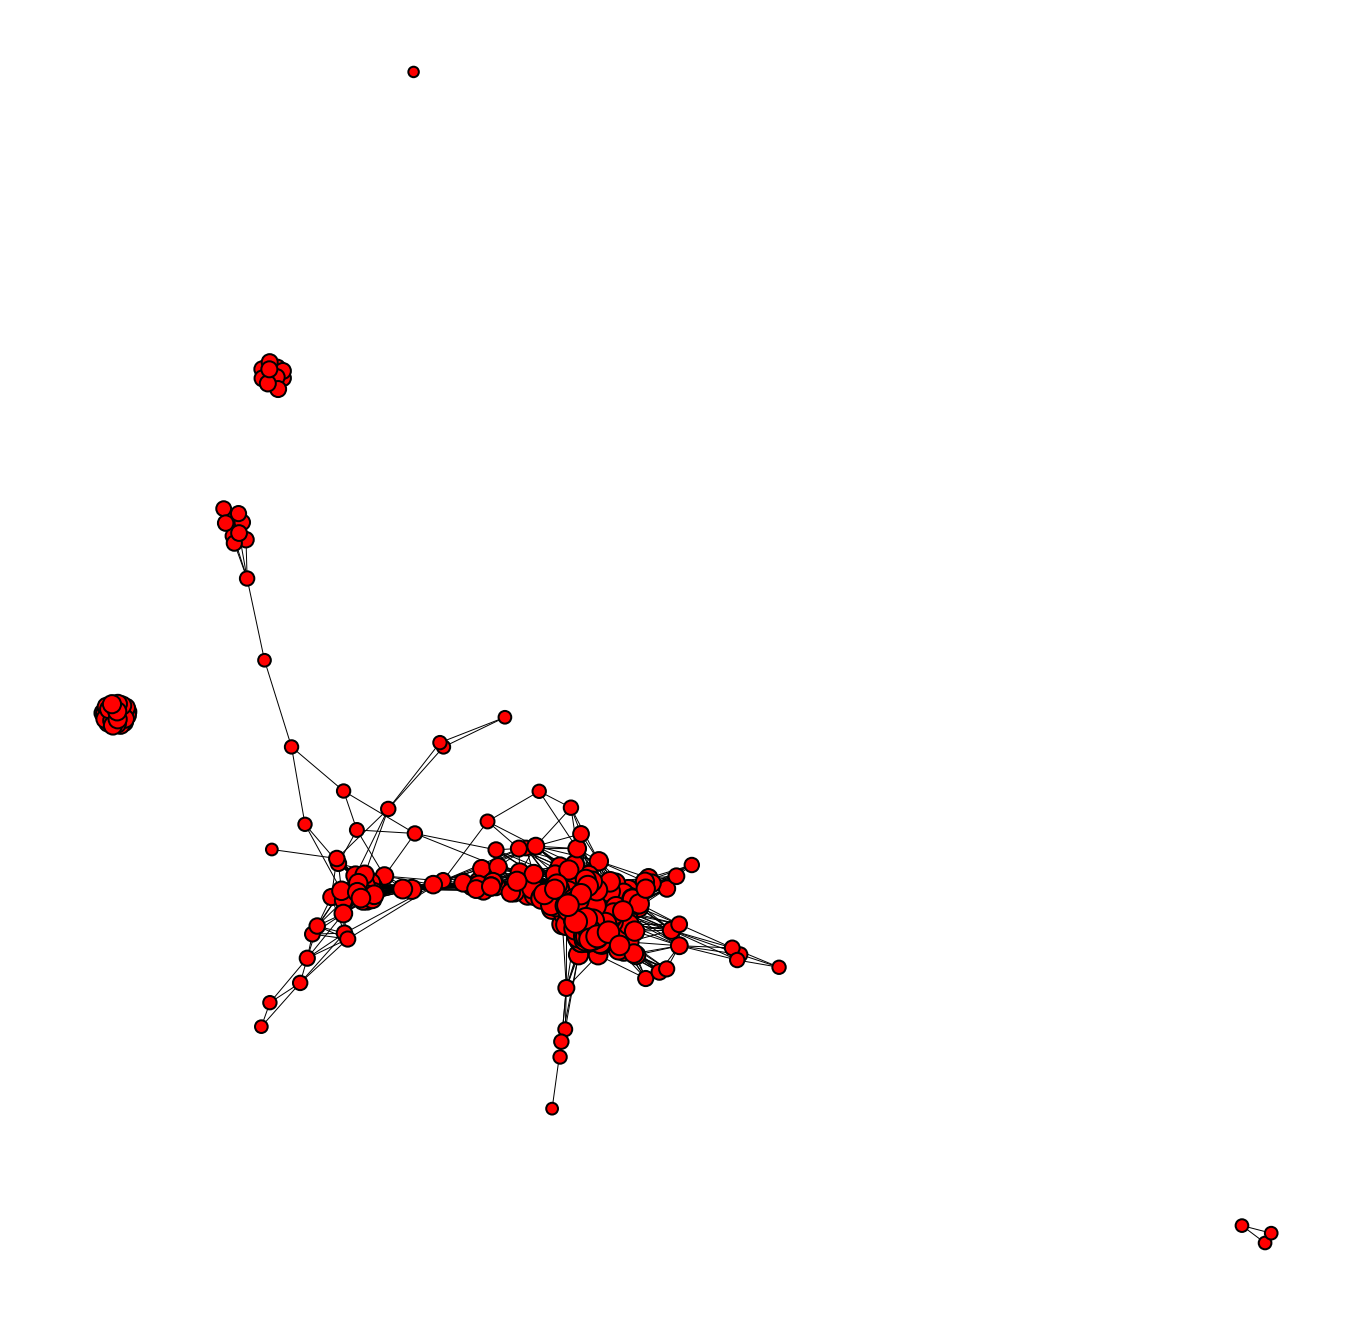

In [170]:
# visualize network
save_and_show_visualization(g, "test.pdf")